In [19]:
import random
from PIL import Image
from pathlib import Path
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from datasets import load_dataset, DatasetDict
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

# Image Captioning using ViT and GPT2
The goal of this notebook is to find accurate descriptions about the person displayed on an image. To do this, we can use a combination of both the ViT and the GPT2 model.  
ViT is a visual model based on the architecture of a transformer originally designed for text-based tasks. The model represents an input image as a series of image patches, like the series of word embeddings used when using transformers to text, and directly predicts class labels for the image.  
GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million webpages.

In [3]:
MODEL = "nlpconnect/vit-gpt2-image-captioning"
gen_kwargs = {"max_length": 25, "num_beams": 4}

## Set up the base model

In [4]:
base_model = VisionEncoderDecoderModel.from_pretrained(MODEL)
feature_extractor = ViTImageProcessor.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

## Set up the data set
RSTPReid contains 20505 images of 4101 persons from 15 cameras. Each person has 5 corresponding images taken by different cameras with complex both indoor and outdoor scene transformations and backgrounds in various periods of time. Each image is annotated with 2 textual descriptions.

In [5]:
DATASET_PATH = Path().resolve().parent / 'RSTPReid'
IMAGE_PATH = DATASET_PATH / 'imgs'

### Splitting the data set
The dataset should be split into a train, test, and validation set. Luckily, the dataset has already done this for us.

In [10]:
%%capture
train_set = load_dataset("json", data_files=str(DATASET_PATH / 'data_captions.json')).filter(lambda example: example['split'] == 'train')["train"];
val_set = load_dataset("json", data_files=str(DATASET_PATH / 'data_captions.json')).filter(lambda example: example['split'] == 'val')["train"];
test_set = load_dataset("json", data_files=str(DATASET_PATH / 'data_captions.json')).filter(lambda example: example['split'] == 'test')["train"];

In [11]:
%%capture
# Make sure we have only one caption per data-example
train_set = train_set.map(lambda example: {"captions": example["captions"][0]}, remove_columns=["split"])
val_set = val_set.map(lambda example: {"captions": example["captions"][0]}, remove_columns=["split"])
test_set = test_set.map(lambda example: {"captions": example["captions"][0]}, remove_columns=["split"])

In [12]:
ds = DatasetDict({"train": train_set, "test": test_set, "validation": val_set})

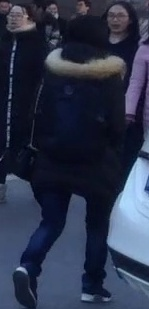

A woman who wears a black overcoat, blue pants and black sneakers is walking with a bag in the street. And she has long and black hair.


In [16]:
# print single example
random_sample = random.randint(0, len(ds['train']))
example = ds['train'][random_sample]

img = Image.open(IMAGE_PATH / example['img_path'])
display(img)
img.close()
print(example['captions'])

### Preprocessing the database
Before the database can be used, we first need to preprocess the data. The model doesn't take the raw image as input, but instead takes in some features of the image. To extract these features, a feature_extractor is available at huggingface.  
Later on, we're going to be retraining (parts of) the model. The output of the model is given in tokens, which can be decoded to get actual, human-understandable text. However, when training, it is better to compare the output with the tokenized versions of the ground truths to calculate the loss. For this reason, we're going to tokenize these ground truths now.

In [17]:
# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions, 
                      padding="max_length", 
                      max_length=max_target_length).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """
    model_inputs = {}
    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(IMAGE_PATH / image_file)
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]
    encoder_inputs = feature_extractor(images=images, return_tensors="np")
    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['img_path']
    captions = examples['captions']
    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)
    return model_inputs

In [99]:
%%capture
processed_dataset = ds.map(function=preprocess_fn, batched=True, fn_kwargs={"max_target_length": 128}, remove_columns=ds['train'].column_names)

Map:   0%|          | 0/18505 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [100]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 18505
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 1000
    })
})

## Investigating the Base Behaviour of the model (without retraining any layers)
Before we can start retraining and evaluating the retrained model, we first need to know how good the base version of the model is on the given task.

### Define a metric
To compare models, we need to define how we're going to score models. 

Many different metrics exist, but I have chosen to use the ROUGE set of metrics. The ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing.  
Alternatives are:
- BLUE: an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
- NIST: a method for evaluating the quality of text which has been translated using machine translation.
- METEOR: a metric for the evaluation of machine translation output.
- WER: a common metric of the performance of a speech recognition or machine translation system.

In [102]:
import evaluate
metric = evaluate.load("rouge")
import numpy as np

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

## Retrain the model

In [104]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=base_model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

In [105]:
trainer.train()

/data/leuven/351/vsc35135/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.save_model("./image-captioning-output")